## VTC Evaluation Steps

In [5]:
pip install numpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 125.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gluoncv 0.10.5.post0 requires opencv-python, which is not installed.
gluoncv 0.10.5.post0 requires portalocker, which is not installed.
gluoncv 0.10.5.post0 requires yacs, which is not installed.
librosa 0.11.0 requires joblib>=1.0, which is not installed.
mmcv 2.2.0 requires opencv-python>=3, which is not installed.
mmengine 0.10.5 requires opencv-python>=3, which is not installed.
mmengine 0.10.5 requires termcolor, which is not installed.
opencv-cuda 0.0.2 requires opencv-python, which is not installed.
scikit-learn 1.3.2 requires joblib>=1.1.1, which is not installed.
tensorboard 2.14.0 requires markdown>=2.6.8, which is not installed.
tensorboard 2.14.0 requi

In [15]:
import logging
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from pyannote.core import Annotation, Segment, Timeline
from pyannote.metrics.detection import DetectionPrecisionRecallFMeasure, DetectionErrorRate
from pyannote.database.util import load_uem
from typing import List
from src.constants import VTCPaths

def plot_annotations_vs_predictions(audio_file_name: str, hypothesis_type: str, time_window: list) -> None:
    """
    Plot ground truth annotations and model predictions for a given audio file and time window.

    Parameters
    ----------
    audio_file_name : str
        The name of the audio file
    hypothesis_type : str
        Hypothesis type: 'og', 'ft', or 'cl'.
    time_window : list
        Start and end time for the plot: [start_time, end_time].
    """
    gt_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)

    hypothesis_paths = {
        'og_01': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_01.pkl'),
        'og_2': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_2.pkl'),
        'ft_01': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_01.pkl'),
        'ft_2': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_2.pkl'),
        'cl_01': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_01.pkl'),
        'cl_2': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_2.pkl')
    }
    if hypothesis_type not in hypothesis_paths:
        raise ValueError("Invalid hypothesis type. Choose from 'og', 'ft', or 'cl'.")

    hypothesis_df = pd.read_pickle(hypothesis_paths[hypothesis_type])
    # Normalize labels
    hypothesis_df['Voice_type'] = hypothesis_df['Voice_type'].str.upper()
    
    # Filter relevant audio file
    gt = gt_df[gt_df['audio_file_name'] == audio_file_name]
    pred = hypothesis_df[hypothesis_df['audio_file_name'] == audio_file_name]

    voice_types = ['KCHI', 'CHI', 'FEM', 'MAL', 'SPEECH']
    colors = {'GT': 'green', 'Pred': 'blue'}

    # Set up the plot
    plt.figure(figsize=(10, 2.75))  # Increased height for more vertical space
    ax = plt.gca()

    row_step = 2  # Increase this value to add more vertical spacing
    yticks = []
    ylabels = []

    for i, vt in enumerate(voice_types[::-1]):  # Reverse order for stacking
        base_y = i * row_step
        for offset, (source_df, label_prefix) in enumerate([(gt, 'GT'), (pred, 'Pred')]):
            y_pos = base_y + offset
            for _, row in source_df[source_df['Voice_type'] == vt].iterrows():
                ax.barh(
                    y=y_pos,
                    width=row['Utterance_Duration'],
                    left=row['Utterance_Start'],
                    color=colors[label_prefix],
                    edgecolor='black',
                    alpha=0.7
                )
            yticks.append(y_pos)
            ylabels.append(f"{label_prefix} {vt}")

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Category")
    ax.set_title("Annotations vs Predictions")
    ax.set_xlim(time_window[0], time_window[1])
    ax.set_ylim(-1, max(yticks) + 2)
    plt.tight_layout()
    plt.show()
    
def combine_pickles(folder_path: str, output_file_name: str) -> None:
    """
    Combines all pickle files in a folder into a single DataFrame and saves it to a new pickle file.

    Parameters:
    - folder_path (str): Path to the folder containing the pickle files.
    - output_path (str): Path to save the combined DataFrame as a pickle file.
    """
    # List to store individual DataFrames
    dataframes = []

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.pkl'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
                dataframes.append(df)

    # Combine all DataFrames into one
    combined_df = pd.concat(dataframes, ignore_index=True)

    output_path = os.path.join(folder_path, output_file_name)
    combined_df.to_pickle(output_path)
    
def rttm_to_dataframe(rttm_file: Path, output_path: Path) -> pd.DataFrame:
    """
    This function reads the voice_type_classifier
    output rttm file and returns its content as a pandas DataFrame.

    Parameters
    ----------
    rttm_file : path
        the path to the RTTM file
    output_path: path
        the path to the output pkl file

    """
    logging.info(f"Reading RTTM file from: {rttm_file}")
    
    try:
        df = pd.read_csv(
            rttm_file,
            sep=" ",
            names=[
                "Speaker",
                "audio_file_name",
                "audio_file_id",
                "Utterance_Start",
                "Utterance_Duration",
                "NA_1",
                "NA_2",
                "Voice_type",
                "NA_3",
                "NA_4",
            ],
        )
    except Exception as e:
        logging.error(f"Failed to read RTTM file: {e}")
        raise
    
    logging.info("Successfully read RTTM file. Processing data...")

    # Drop unnecessary columns
    df = df.drop(columns=["Speaker", "audio_file_id", "NA_1", "NA_2", "NA_3", "NA_4"])  # noqa: E501
    df["Utterance_End"] = df["Utterance_Start"] + df["Utterance_Duration"]
    
    logging.info("Data processing complete. Returning DataFrame.")

    try:
        df.to_pickle(output_path)
        logging.info(f"DataFrame successfully saved to: {output_path}")
    except Exception as e:
        logging.error(f"Failed to save DataFrame to file: {e}")
        raise

def dataframe_to_annotation(df, label_column="Voice_type"):
    """
    Converts a DataFrame to a pyannote.core.Annotation object.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterance_Start', 'Utterance_End', and a label column.
    - label_column (str): Column name for the labels (default: 'Voice_type').

    Returns:
    - Annotation: pyannote.core.Annotation object.
    """
    annotation = Annotation()
    for _, row in df.iterrows():
        start = float(row["Utterance_Start"])
        end = float(row["Utterance_End"])
        label = row[label_column]
        annotation[Segment(start, end)] = label
    return annotation

def compute_metrics(hypothesis_type: str) -> None:
    """
    Computes and prints the detection metrics for the given hypothesis type.
    Parameters
    ----------
    hypothesis_type : str
        The type of hypothesis to compute metrics for. Options are 'og', 'ft', or 'cl'.
    """
    hypothesis_paths = {
        'og_01': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_01.pkl'),
        'og_2': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_2.pkl'),
        'ft_01': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_01.pkl'),
        'ft_2': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_2.pkl'),
        'cl_01': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_01.pkl'),
        'cl_2': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_2.pkl')
    }
    if hypothesis_type not in hypothesis_paths:
        raise ValueError("Invalid hypothesis type. Choose 'og', 'ft', or 'cl'.")
    
    hypothesis_path = hypothesis_paths[hypothesis_type]

    reference_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)
    hypothesis_df = pd.read_pickle(hypothesis_path)
    
    # Normalize labels
    reference_df['Voice_type'] = reference_df['Voice_type'].replace({'OCH': 'CHI'})
    hypothesis_df['Voice_type'] = hypothesis_df['Voice_type'].str.upper().replace({'OCH': 'CHI'})

    # Find common audio_file_names present in both reference and hypothesis
    reference_files_set = set(reference_df['audio_file_name'].unique())
    hypothesis_files_set = set(hypothesis_df['audio_file_name'].unique())
    
    annotated_files = list(reference_files_set.intersection(hypothesis_files_set))
    
    if not annotated_files:
        print(f"Warning: No common audio files found between reference and hypothesis for type '{hypothesis_type}'. Metrics cannot be computed.")
        return

    # Filter both DataFrames to only include these common files
    # This ensures that when we iterate through annotated_files, both DFs will have entries for that file.
    reference_df = reference_df[reference_df['audio_file_name'].isin(annotated_files)]
    predictions_df = hypothesis_df[hypothesis_df['audio_file_name'].isin(annotated_files)]
    
    # Define the UEM file path and load it once before the loop
    uem_file_path = "/home/nele_pauline_suffo/ProcessedData/vtc_childlens/complete.uem"
    try: 
        all_video_uems = load_uem(uem_file_path)
    except FileNotFoundError:
        print(f"Warning: UEM file not found at {uem_file_path}. UEM will be approximated.")
        all_video_uems = {}
    except Exception as e:
        print(f"Warning: Error loading UEM file {uem_file_path}: {e}. UEM will be approximated.")
        all_video_uems = {}

    voice_types = ['KCHI', 'CHI', 'FEM', 'MAL', 'SPEECH']
    metric_names = ['precision', 'recall', 'f1_score', 'error_rate']
    
    # More compact initialization for class_metrics
    class_metrics_results = {
        vt: {metric_name: [] for metric_name in metric_names}
        for vt in voice_types
    }

    for video_filename in annotated_files:
        ref_video_df = reference_df[reference_df['audio_file_name'] == video_filename]
        pred_video_df = predictions_df[predictions_df['audio_file_name'] == video_filename]

        if ref_video_df.empty:
            # This case should ideally not happen if annotated_files is derived from reference_df
            print(f"Warning: No reference annotations found for video: {video_filename}, though it was in annotated_files. Skipping.")
            continue
        # Get the UEM Timeline for the current video_filename
        # Ensure video_filename matches the URI key in the UEM file
        current_video_uem: Optional[Timeline] = all_video_uems.get(video_filename)
        if current_video_uem is None:
            # This print is optional, as pyannote will warn if it approximates
            print(f"Info: No UEM entry found for {video_filename} in {uem_file_path} . UEM will be approximated for this file.")
            pass
        
        for voice_type in voice_types:
            ref_class_video_df = ref_video_df[ref_video_df['Voice_type'] == voice_type]
            pred_class_video_df = pred_video_df[pred_video_df['Voice_type'] == voice_type]

            reference_annotation = dataframe_to_annotation(ref_class_video_df)
            hypothesis_annotation = dataframe_to_annotation(pred_class_video_df)

            # Initialize metric objects for each video-class pair to get non-accumulated scores
            detection_pr_f1_metric = DetectionPrecisionRecallFMeasure(collar=0, skip_overlap=False)
            detection_error_metric = DetectionErrorRate(collar=0, skip_overlap=False)

            # Compute metrics
            _ = detection_pr_f1_metric(reference_annotation, hypothesis_annotation, uem=current_video_uem)
            p, r, f1 = detection_pr_f1_metric.compute_metrics()
            error_rate = detection_error_metric(reference_annotation, hypothesis_annotation, uem=current_video_uem)

            class_metrics_results[voice_type]['precision'].append(p)
            class_metrics_results[voice_type]['recall'].append(r)
            class_metrics_results[voice_type]['f1_score'].append(f1)
            class_metrics_results[voice_type]['error_rate'].append(error_rate)

    print(f"\nAveraged Metrics Per Class Over All Videos (Hypothesis: {hypothesis_type.upper()}):")
    
    overall_macro_f1_components = []

    for voice_type in voice_types:
        print(f"Class '{voice_type.upper()}':")
        for metric_name in metric_names:
            metric_values = class_metrics_results[voice_type][metric_name]
            
            # Filter out NaN values before averaging
            valid_metric_values = [v for v in metric_values if not pd.isna(v)]
            
            if valid_metric_values:
                avg_metric = sum(valid_metric_values) / len(valid_metric_values)
            else:
                avg_metric = 0.0  # Or float('nan') if you prefer to show NaN for no valid scores

            print(f"  Average {metric_name.replace('_', ' ').capitalize()}: {avg_metric:.3f}")
            
            if metric_name == 'f1_score':
                overall_macro_f1_components.append(avg_metric)
        print("") # Newline for readability between classes

    if overall_macro_f1_components:
        final_macro_f1_score = sum(overall_macro_f1_components) / len(overall_macro_f1_components)
    else:
        final_macro_f1_score = 0.0 # Or float('nan')

    print(f"Final Macro F1 Score (average of per-class average F1 scores): {final_macro_f1_score:.3f}")

### 1. Convert Output RTTM to Dataframe

In [9]:
rttm_og_01_file_path = "/home/nele_pauline_suffo/outputs/vtc/childlens_audio_01/all.rttm"
rttm_og_2_file_path = "/home/nele_pauline_suffo/outputs/vtc/childlens_audio_2/all.rttm"

rttm_ft_01_file_path = "/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_audio_01/all.rttm"
rttm_ft_2_file_path = "/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_audio_2/all.rttm"

rttm_cl_01_file_path = "/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_audio_01/all.rttm"

output_og_01_file_path = "/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_01.pkl"
output_og_2_file_path = "/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_2.pkl"

output_ft_01_file_path = "/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_01.pkl"
output_ft_2_file_path = "/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_2.pkl"

output_cl_01_file_path = "/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_01.pkl"

rttm_to_dataframe(rttm_og_01_file_path, output_og_01_file_path)
rttm_to_dataframe(rttm_og_2_file_path, output_og_2_file_path)
rttm_to_dataframe(rttm_ft_01_file_path, output_ft_01_file_path)
rttm_to_dataframe(rttm_ft_2_file_path, output_ft_2_file_path)
rttm_to_dataframe(rttm_cl_01_file_path, output_cl_01_file_path)

### 2. Compute Evaluation Metrics

In [11]:
compute_metrics('og_2')


Averaged Metrics Per Class Over All Videos (Hypothesis: OG_2):
Class 'KCHI':
  Average Precision: 0.742
  Average Recall: 0.692
  Average F1 score: 0.683
  Average Error rate: 0.663

Class 'CHI':
  Average Precision: 0.048
  Average Recall: 0.862
  Average F1 score: 0.054
  Average Error rate: 4.556

Class 'FEM':
  Average Precision: 0.359
  Average Recall: 0.778
  Average F1 score: 0.410
  Average Error rate: 9.331

Class 'MAL':
  Average Precision: 0.301
  Average Recall: 0.702
  Average F1 score: 0.252
  Average Error rate: 2.697

Class 'SPEECH':
  Average Precision: 0.830
  Average Recall: 0.856
  Average F1 score: 0.822
  Average Error rate: 1.206

Final Macro F1 Score (average of per-class average F1 scores): 0.444


In [12]:
compute_metrics('og_01')


Averaged Metrics Per Class Over All Videos (Hypothesis: OG_01):
Class 'KCHI':
  Average Precision: 0.781
  Average Recall: 0.567
  Average F1 score: 0.628
  Average Error rate: 0.666

Class 'CHI':
  Average Precision: 0.049
  Average Recall: 0.847
  Average F1 score: 0.053
  Average Error rate: 3.846

Class 'FEM':
  Average Precision: 0.388
  Average Recall: 0.663
  Average F1 score: 0.394
  Average Error rate: 6.945

Class 'MAL':
  Average Precision: 0.306
  Average Recall: 0.674
  Average F1 score: 0.239
  Average Error rate: 2.398

Class 'SPEECH':
  Average Precision: 0.871
  Average Recall: 0.725
  Average F1 score: 0.770
  Average Error rate: 1.094

Final Macro F1 Score (average of per-class average F1 scores): 0.417


In [13]:
compute_metrics('ft_2')


Averaged Metrics Per Class Over All Videos (Hypothesis: FT_2):
Class 'KCHI':
  Average Precision: 0.768
  Average Recall: 0.854
  Average F1 score: 0.793
  Average Error rate: 0.469

Class 'CHI':
  Average Precision: 0.092
  Average Recall: 0.882
  Average F1 score: 0.100
  Average Error rate: 3.379

Class 'FEM':
  Average Precision: 0.542
  Average Recall: 0.700
  Average F1 score: 0.532
  Average Error rate: 1.579

Class 'MAL':
  Average Precision: 0.533
  Average Recall: 0.722
  Average F1 score: 0.455
  Average Error rate: 0.895

Class 'SPEECH':
  Average Precision: 0.817
  Average Recall: 0.933
  Average F1 score: 0.864
  Average Error rate: 0.338

Final Macro F1 Score (average of per-class average F1 scores): 0.549


In [14]:
compute_metrics('ft_01')


Averaged Metrics Per Class Over All Videos (Hypothesis: FT_01):
Class 'KCHI':
  Average Precision: 0.807
  Average Recall: 0.801
  Average F1 score: 0.790
  Average Error rate: 0.441

Class 'CHI':
  Average Precision: 0.095
  Average Recall: 0.876
  Average F1 score: 0.100
  Average Error rate: 3.087

Class 'FEM':
  Average Precision: 0.566
  Average Recall: 0.650
  Average F1 score: 0.520
  Average Error rate: 1.402

Class 'MAL':
  Average Precision: 0.542
  Average Recall: 0.705
  Average F1 score: 0.449
  Average Error rate: 0.867

Class 'SPEECH':
  Average Precision: 0.848
  Average Recall: 0.902
  Average F1 score: 0.867
  Average Error rate: 0.312

Final Macro F1 Score (average of per-class average F1 scores): 0.545


In [ ]:
compute_metrics('cl_01')


Averaged Metrics Per Class Over All Videos (Hypothesis: CL):
Class 'KCHI':
  Average Precision: 0.806
  Average Recall: 0.811
  Average F1 score: 0.797
  Average Error rate: 0.459

Class 'CHI':
  Average Precision: 0.077
  Average Recall: 0.902
  Average F1 score: 0.089
  Average Error rate: 3.992

Class 'FEM':
  Average Precision: 0.566
  Average Recall: 0.655
  Average F1 score: 0.521
  Average Error rate: 1.660

Class 'MAL':
  Average Precision: 0.499
  Average Recall: 0.732
  Average F1 score: 0.427
  Average Error rate: 0.893

Class 'SPEECH':
  Average Precision: 0.895
  Average Recall: 0.791
  Average F1 score: 0.824
  Average Error rate: 0.411

Final Macro F1 Score (average of per-class average F1 scores): 0.532


## Plot Results

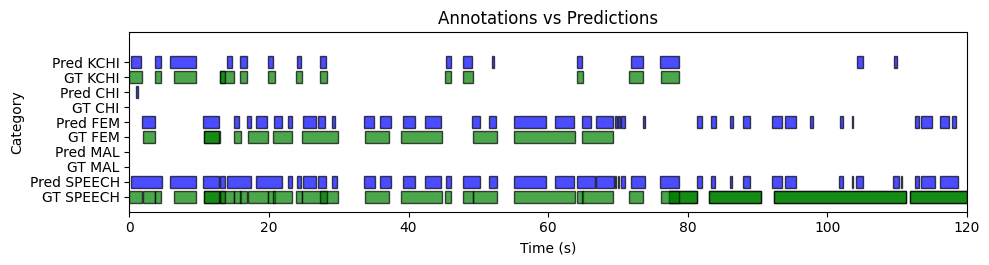

In [16]:
plot_annotations_vs_predictions('100898.MP4', "og_01", [0, 120])

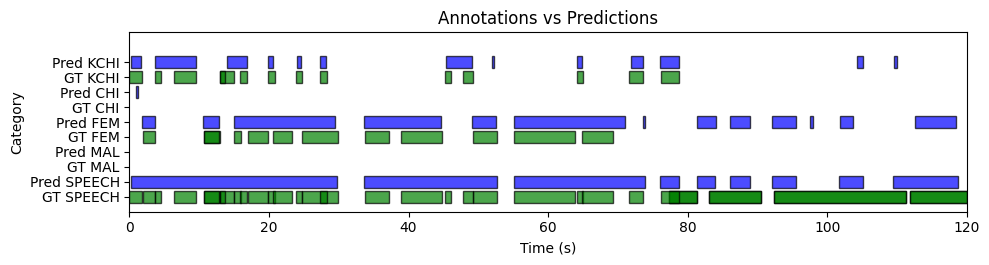

In [17]:
plot_annotations_vs_predictions('100898.MP4', "og_2", [0, 120])

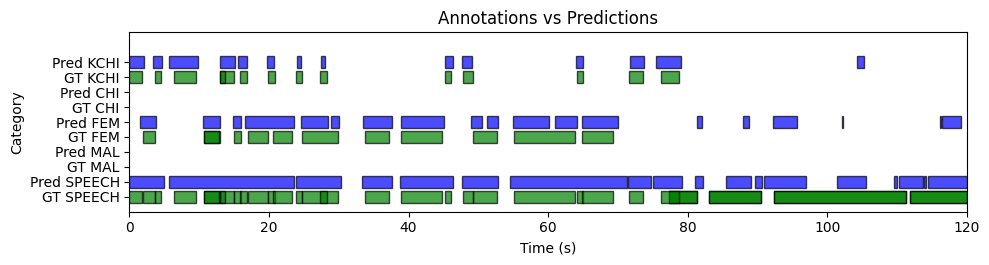

In [18]:
plot_annotations_vs_predictions('100898.MP4', "ft_01", [0, 120])

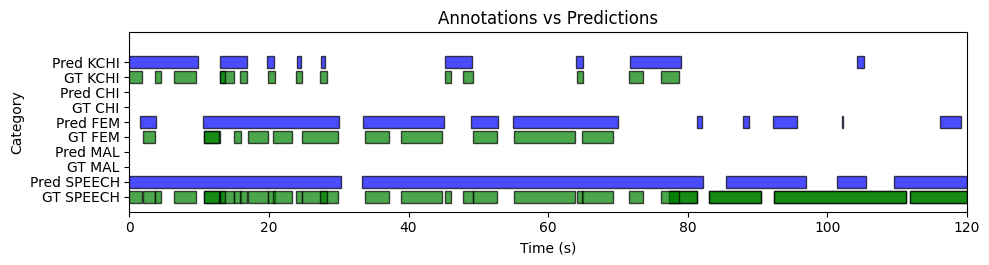

In [19]:
plot_annotations_vs_predictions('100898.MP4', "ft_2", [0, 120])

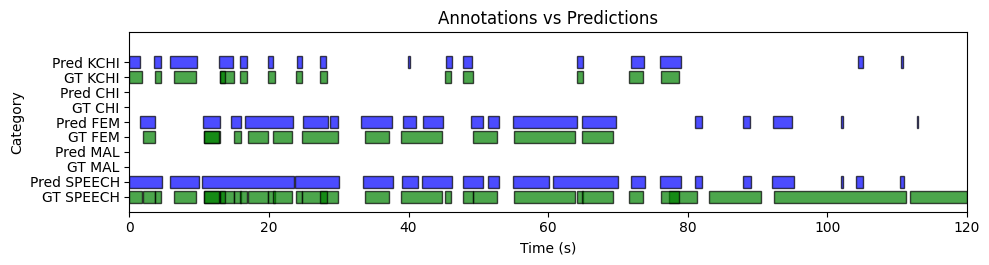

In [48]:
plot_annotations_vs_predictions('100898.MP4', "cl", [0, 120])

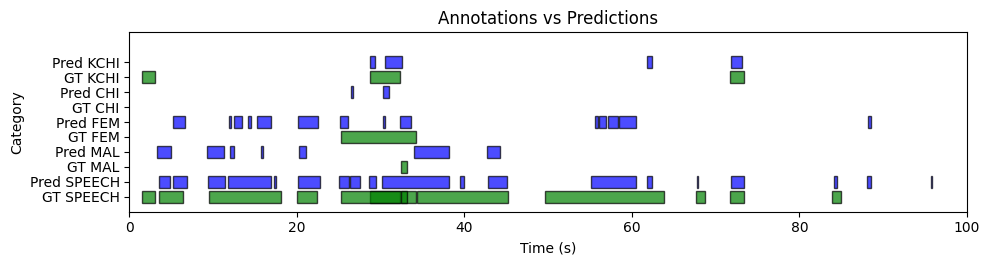

In [43]:
plot_annotations_vs_predictions('410731.MP4', "og", [0, 100])

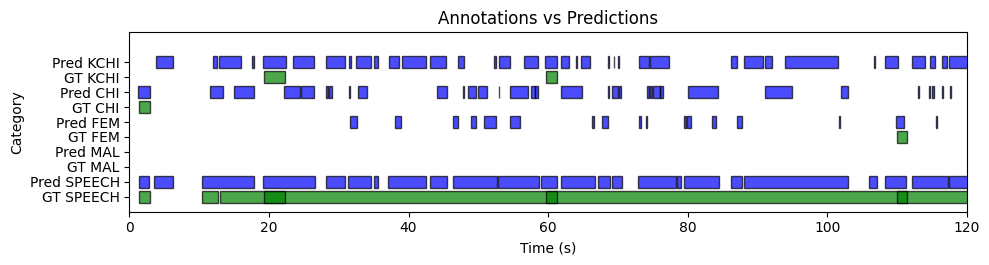

In [44]:
plot_annotations_vs_predictions('336244.MP4', "og", [0, 120])

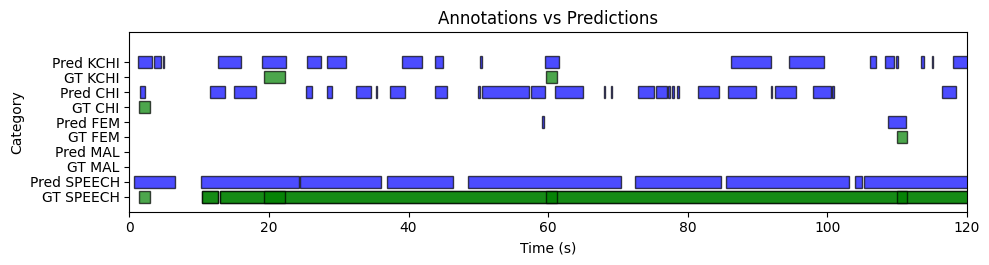

In [3]:
plot_annotations_vs_predictions('336244.MP4', "ft", [0, 120])

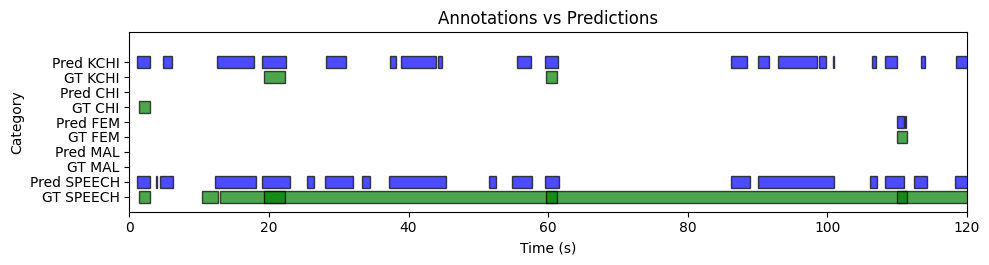

In [49]:
plot_annotations_vs_predictions('336244.MP4', "cl", [0, 120])

### Length of each Voice Type Class

In [3]:
gt_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)
# sum utterance durations for each Voice_type in minutes (divide by 60)
gt_df.groupby('Voice_type')['Utterance_Duration'].sum() / 60

Voice_type
CHI         43.977633
FEM        455.907233
KCHI       859.266517
MAL        200.408267
SPEECH    2361.872283
Name: Utterance_Duration, dtype: float64

### Utils: Convert audio to 16khz sampling rate

In [ ]:
import os
from pathlib import Path
from pydub import AudioSegment
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def convert_to_16khz(input_folder: Path, output_folder: Path) -> None:
    """Convert all audio files in a folder to 16kHz sampling rate.
    
    Parameters
    ----------
    input_folder : Path
        Path to folder containing audio files
    output_folder : Path
        Path where converted files will be saved
    """
    # Create output folder if it doesn't exist
    output_folder.mkdir(parents=True, exist_ok=True)
    
    # Supported audio formats
    audio_extensions = ('.wav', '.mp3', '.m4a', '.flac')
    
    # Get all audio files
    audio_files = [f for f in input_folder.iterdir() if f.suffix.lower() in audio_extensions]
    
    if not audio_files:
        logging.warning(f"No audio files found in {input_folder}")
        return
        
    for audio_file in audio_files:
        try:
            # Load audio file
            audio = AudioSegment.from_file(audio_file)
            
            # Convert to 16kHz
            audio_16k = audio.set_frame_rate(16000)
            
            # Create output path
            output_path = output_folder / f"{audio_file.stem}_16k{audio_file.suffix}"
            
            # Export converted audio
            audio_16k.export(output_path, format=output_path.suffix.replace('.', ''))
            
            logging.info(f"Converted: {audio_file.name}")
            
        except Exception as e:
            logging.error(f"Error converting {audio_file.name}: {e}")

if __name__ == "__main__":
    # Example usage
    input_folder = Path("/home/nele_pauline_suffo/ProcessedData/quantex_audio")
    output_folder = Path("/home/nele_pauline_suffo/ProcessedData/quantex_audio_16khz")
    
    convert_to_16khz(input_folder, output_folder)